Polar Plots (Figure 6)


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import collections
from collections import Counter

In [2]:
azi_avg2 = []
ele_avg2 = []
azi_avg3 = []
ele_avg3 = []

In [3]:
'Framing Real Data'

def data_framing(file):
    df = pd.read_csv(file,header=None,delim_whitespace=True)
    freq = df[1].to_numpy()
    ele = df[3].to_numpy()
    azi = df[4].to_numpy()
    data_degrees = list(zip(azi,ele))
    data_radians = [(np.deg2rad(a), r) for a, r in data_degrees]
    data_array = np.array(data_radians)
    azi_mean = stats.circmean(data_array[:,0])
    ele_mean = np.rad2deg(stats.circmean(np.deg2rad(data_array[:,1])))
    return(freq,ele,azi,data_degrees,data_radians,data_array,azi_mean,ele_mean)


In [ ]:
'Use for the alias selected cases'

#Aliased Files for 4_10: [19,20,22,27]

filenumber = 27
filepath = '/Volumes/PassportDrive/interferometer-data/data-sent-by-jim/DataCopy/new_data/radial-plots/better-radial-plots/'
filepath_len = len(filepath)
files2fce = glob.glob('{}used-2fce-data/*.csv'.format(filepath))
files3fce = glob.glob('{}used-3fce-data/*.csv'.format(filepath))
file2 = files2fce[filenumber]
file3 = files3fce[filenumber]
filename = file3[ filepath_len + 15 : filepath_len + 33 ]


In [44]:
'Framing Ideal Data with .gnuplot extension'

def ideal_data_frame_gnu(path,files,maxpow):
    
    output_folder = sorted(glob.glob("{}{}/*.gnuplot".format(path,files)))
    df_all_rows = pd.concat([pd.read_csv(item,header=None,delim_whitespace=True) for item in output_folder],axis = 0,ignore_index=True)

    df_maxpower = df_all_rows[df_all_rows[3] >= maxpow]
    df = df_maxpower.drop_duplicates(subset=[0], keep='first', inplace=False)
    
    input_azimuth_list = []
    input_elevation_list = []

    for i in df[0]:
        input_azimuth_list.append(float(i[9:13]))
        input_elevation_list.append(float(i[14:18]))
    
    input_azimuth = np.array(input_azimuth_list)
    input_elevation = np.array(input_elevation_list)
    power = df[3].to_numpy(dtype=float)
    output_azimuth_180 = df[4].to_numpy(dtype=float)
    output_azimuth_list = [angle + 360 if angle < 0 else angle for angle in output_azimuth_180]
    output_azimuth = np.array(output_azimuth_list)
    output_elevation = df[5].to_numpy(dtype=float)
    
    return(input_azimuth,input_elevation,power,output_azimuth,output_elevation)


In [45]:
'Framing Ideal Data with .txt extension'

def ideal_data_frame_txt(path,files,maxpow):
    
    output_folder = sorted(glob.glob("{}{}/*.txt".format(path,files)))
    df_all_rows = pd.concat([pd.read_csv(item,header=None,delim_whitespace=True) for item in output_folder],axis = 0,ignore_index=True)
    
    df = df_all_rows[df_all_rows[3] >= maxpow]    
    input_azimuth_list = []
    input_elevation_list = []
    
    for full_path in output_folder:
        input_azimuth_list.append(int(full_path[76:79]))
        input_elevation_list.append(int(full_path[82:84]))
    
    input_azimuth = np.array(input_azimuth_list)
    input_elevation = np.array(input_elevation_list)
    power = df[3].to_numpy(dtype=float)
    output_azimuth_180 = df[4].to_numpy(dtype=float)
    output_azimuth_list = [angle + 360 if angle < 0 else angle for angle in output_azimuth_180]
    output_azimuth = np.array(output_azimuth_list)
    output_elevation = df[5].to_numpy(dtype=float)
    
    return(input_azimuth,input_elevation,power,output_azimuth,output_elevation)


In [46]:
'4.1 MHz Aliased Regions'

path = 'aliased_dataset/'
files = '4_10_MHz/files'
maxpow = 779.
input_azimuth,input_elevation,power,output_azimuth,output_elevation = ideal_data_frame_txt(path,files,maxpow)

Z_az_41 = np.reshape(output_azimuth,(181,41))
Z_el_41 = np.reshape(output_elevation,(181,41))

#Other frequency options and their max power:
 # 2_80/files : 779 (.gnuplot)
 # 3_90/files : 751 (.txt)
 # 4_10/files : 779 (.txt extension)
 # 4_30/files : 768 (.gnuplot)
 # 5_25/files : 770 (.txt)
 # 5_80/files : 741 (.txt)


In [47]:
'Finding Aliases for Real Data using Z from Ideal Data'

def find_alias(test_el,test_az,Z_el,Z_az,text_output=False):
    
#create testpoint
    testpoint = np.array([test_el,test_az])
# initialize filtered arrays to all zeros
    elfiltered = np.zeros((181,41),dtype=int)
    azfiltered = np.zeros((181,41),dtype=int)
# filtering process
    for i in range(181):
        for j in range(41):
            if abs(Z_el[i,j]-testpoint[0]) <= 1:
                elfiltered[i,j] = 1
            if abs(Z_az[i,j] - testpoint[1]) <= 1:
                azfiltered[i,j] = 1
# finding solutions
    solution = []
    count = 0 #counter for the number of solutions
    for i in range(181):
        for j in range(41):
            if elfiltered[i,j] == 1 and azfiltered[i,j]==1:
                count += 1
                solution.append([5+j*2,2*i])
    if text_output == True:
        # output solutions
        if count == 0:
            print("There are no solutions.")
        else:
            print(f"Total solutions found: {count}") 
            for sol in solution:
                print(f"Solution: Elevation {sol[0]}, Azimuth {sol[1]}")
    return(testpoint, count, solution)

# saving all solutions as a list of dictionaries 
all_solutions = []
for (el, az) in zip(ele3,azi3):
    testpoint, count, solution = find_alias(el,az,Z_el_41,Z_az_41)
    all_solutions.append({"real_el_and_az":testpoint,"count":count, "solutions":solution})
    
test = []
for entry in all_solutions:
    for solution in entry["solutions"]:
        test.append(solution)
el_solns_3 = [item[0] for item in test]
az_solns = [item[1] for item in test]


In [48]:
'Filtering 3fce azimuth for events where aliased azimuth is closer to 2fce azimuth'

az_filtered3 = []
el_filtered3 = []

'19'
#for i,angle in enumerate(az_solns):
#    if (angle>180) & (angle<270):
#        az_filtered3.append(angle)
#        el_filtered3.append(el_solns_3[i])
'20'
#for i,angle in enumerate(az_solns):
#    if (angle>0) & (angle<90):
#        az_filtered3.append(angle)
#        el_filtered3.append(el_solns_3[i])
'22'
#for i,angle in enumerate(az_solns):
#    if (angle>90) & (angle<180):
#        az_filtered3.append(angle)
#        el_filtered3.append(el_solns_3[i])
'27'
for i,angle in enumerate(az_solns):
    if (angle>180) & (angle<270):
        az_filtered3.append(angle)
        el_filtered3.append(el_solns_3[i])

az_solns_radians_3 = np.deg2rad(az_filtered3)
azi3_mean_aliased = stats.circmean(az_solns_radians_3)
ele3_mean_aliased = np.rad2deg(stats.circmean(np.deg2rad(el_filtered3)))

azi_avg2.append(azi2_mean)
ele_avg2.append(ele2_mean)
azi_avg3.append(azi3_mean_aliased)
ele_avg3.append(ele3_mean_aliased)

In [4]:
'After Filtering 3fce azimuth above, paste into these to save angles permanantly; check-point.'

azi_avg2_done = [60.12149562,233.09657079,78.95032228,335.10653092,264.29812865,198.52009374,182.74563841,134.82260899,96.58705153,178.635523,192.31060735,71.38884661,244.98868379,41.24416285,114.97064423,310.37541733,4.70200558,156.66065972,294.23144236,228.67544601,36.66922914,175.11526333,224.96437954,19.5619875,141.38027146,94.61193302,180.93520585,242.42320021,296.13862008,182.36527237,110.58258744,209.24363463,115.8363441,348.74022173,170.92473827,65.75965163,88.69621667,213.08665505,150.68402215,243.0155231,19.6432004,153.08089603]
ele_avg2_done = [67.15130012707593,64.68949887003478,60.484348419894,72.43834717513427,23.229961138756856,77.48978941672621,61.4092214691919,60.20201702168971,49.63137741450088,67.24828993063204,82.42191209699688,47.50280276267172,39.92211683010526,50.92729075369107,61.11036776862862,49.424877325822266,73.56365040982392,70.71959359359073,28.95774174694146,31.012128420176296,60.141214067104364,58.259316733943976,31.566906359532606,61.23411777717499,38.29073673909891,59.387549762469476,53.141874646025265,28.806200500367797,38.54877729272651,61.890050019661224,56.50689109238669,73.49717420547174,58.34441061336252,73.14961204332845,64.29879049680683,48.39847554565779,44.15634129488931,71.36819674763944,47.69492765935301,70.78646233022621,80.85179070983034,74.44933335388853]
azi_avg3_done = [66.78213196,137.77869882,178.28950559,34.42078741,239.85051108,208.75109325,303.08819675,136.48050156,143.89352346,166.47565405,209.87604959,219.31089688,237.39517872,57.56568229,229.58262217,333.1112304,57.33123114,163.3372651,211.15167556,240.95798523309642,57.459694798941264,210.0130679979495,163.07446628,272.8291931,145.10714953,222.61420554,220.07056983,249.61024678684328,265.61714165,245.59952563,130.13587318,243.10219836,357.12667096,5.12059515,160.81654406,171.94077447,128.41212472,12.24496914,274.92612988,240.28077987,253.97048685,213.62816889]
ele_avg3_done = [49.83946932643849,71.23565314262396,66.080641790219,72.79237860982003,58.916464332301985,63.33672187839319,74.91186780144943,64.83976125137076,70.20121009630485,68.98575241728238,77.27895392422764,59.28326422827979,52.442582343564,52.0542120558063,56.46804395625506,66.63871625105897,71.8599140126813,71.62296368664272,62.880245461393955,23.724931656100043,13.999249871495428,62.12459755345066,34.89742308265778,82.85327226544696,52.65175603525841,64.31278760396386,59.18677002369161,27.94727330004767,78.46582388013206,51.46822661634557,69.58177629509241,78.93428285874464,84.28280609563599,64.24906148610629,62.6566928264254,82.76685936821032,69.48679725947804,76.80023478894175,48.73656264429961,77.33226958179752,62.96386858554017,64.8158287786544]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


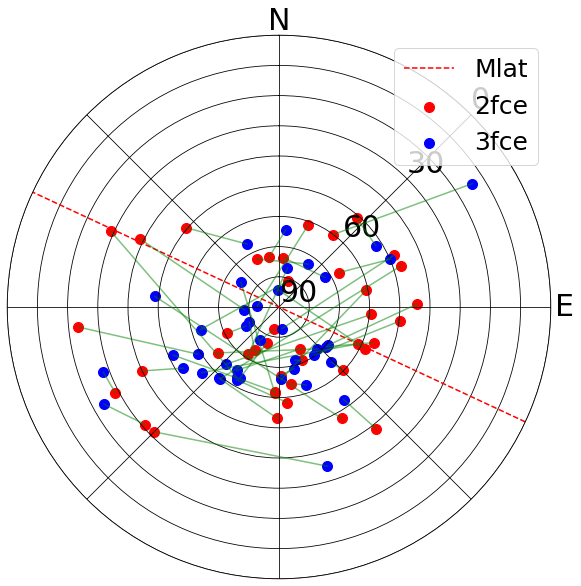

In [5]:
'All 42 2fce and 3fce mean azimuth & elevation each pair with a green line indicating simultaneous occurence. '

data_degrees2 = list(zip(azi_avg2_done,ele_avg2_done))
data_degrees3 = list(zip(azi_avg3_done,ele_avg3_done))
data_radians2 = [(np.deg2rad(a), r) for a, r in data_degrees2]
data_radians3 = [(np.deg2rad(a), r) for a, r in data_degrees3]
data_array2 = np.array(data_radians2)
data_array3 = np.array(data_radians3)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_rlim(bottom=90, top=0)
ax.xaxis.grid(True,color='k')
ax.yaxis.grid(True,color='k')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_yticklabels(['0','','','30','','','60','','','90'],fontsize=30,color='k')
ax.set_rlabel_position(45.0)
ax.set_xticklabels(['N', '', 'E', '', '', '', '', ''],fontsize=30,color='k')

r = 0.01
localBnorth = np.deg2rad(90. + 25.)
localBsouth = np.deg2rad(270. + 25.)
ax.plot([localBnorth,localBsouth], [r,r], color='r', linestyle='--', alpha=1,label='Mlat')

ax.scatter(data_array2[:, 0], data_array2[:, 1], color='r', s=100, alpha=1, label='2fce')
ax.scatter(data_array3[:, 0], data_array3[:, 1], color='b', s=100, alpha=1, label='3fce')

for (angle_2, radius_2), (angle_3, radius_3) in zip(data_array2, data_array3):
    ax.plot([angle_2, angle_3], [radius_2, radius_3], color='g', alpha=0.5)
    x_2, y_2 = radius_2 * np.cos(angle_2), radius_2 * np.sin(angle_2)
    x_3, y_3 = radius_3 * np.cos(angle_3), radius_3 * np.sin(angle_3)
    distance = np.sqrt((x_3 - x_2) ** 2 + (y_3 - y_2) ** 2)

ax.legend(fontsize=25)
#plt.savefig('figures/figure6/polar_plot_all_42.png',transparent=True)
plt.show()


Nummber of event pairs:  23


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


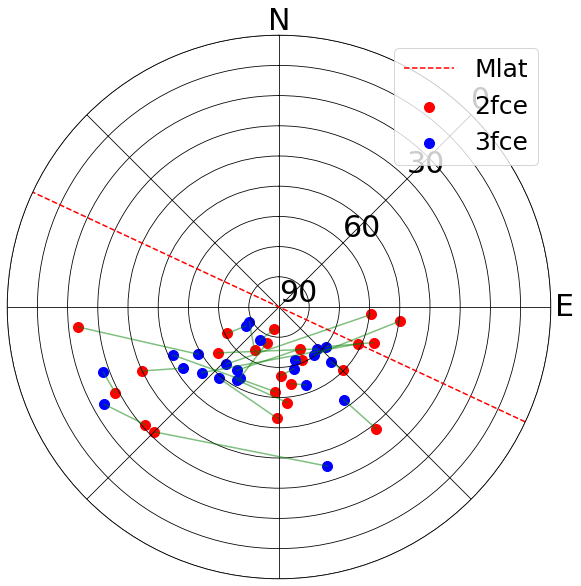

In [8]:
'Geographic South Polar Plot'

azi2_all = []
ele2_all = []
azi3_all = []
ele3_all = []

for i,angle in enumerate(azi_avg2_done):
    if (angle<=270 and angle>=90) and (azi_avg3_done[i]<=270 and azi_avg3_done[i]>=90):
        ele2_all.append(ele_avg2_done[i])
        azi2_all.append(angle)
        ele3_all.append(ele_avg3_done[i])
        azi3_all.append(azi_avg3_done[i])
print('Nummber of event pairs: ',len(ele2_all))
        
data_degrees2 = list(zip(azi2_all,ele2_all))
data_degrees3 = list(zip(azi3_all,ele3_all))
data_radians2 = [(np.deg2rad(a), r) for a, r in data_degrees2]
data_radians3 = [(np.deg2rad(a), r) for a, r in data_degrees3]
data_array2 = np.array(data_radians2)
data_array3 = np.array(data_radians3)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_rlim(bottom=90, top=0)
ax.xaxis.grid(True,color='k')
ax.yaxis.grid(True,color='k')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_yticklabels(['0','','','30','','','60','','','90'],fontsize=30,color='k')
ax.set_rlabel_position(45.0)
ax.set_xticklabels(['N', '', 'E', '', '', '', '', ''],fontsize=30,color='k')

r = 0.01
localBnorth = np.deg2rad(90. + 25.)
localBsouth = np.deg2rad(270. + 25.)
ax.plot([localBnorth,localBsouth], [r,r], color='r', linestyle='--', alpha=1,label='Mlat')

ax.scatter(data_array2[:, 0], data_array2[:, 1], color='r', s=100, alpha=1, label='2fce')
ax.scatter(data_array3[:, 0], data_array3[:, 1], color='b', s=100, alpha=1, label='3fce')

for (angle_2, radius_2), (angle_3, radius_3) in zip(data_array2, data_array3):
    ax.plot([angle_2, angle_3], [radius_2, radius_3], color='g', alpha=0.5)
    x_2, y_2 = radius_2 * np.cos(angle_2), radius_2 * np.sin(angle_2)
    x_3, y_3 = radius_3 * np.cos(angle_3), radius_3 * np.sin(angle_3)
    distance = np.sqrt((x_3 - x_2) ** 2 + (y_3 - y_2) ** 2)

ax.legend(fontsize=25)
#plt.savefig('figures/figure6/polar_plot_south.png',transparent=True)
plt.show()


0 :  49.83946932643849
7 :  64.83976125137076
12 :  52.442582343564
17 :  71.62296368664272
24 :  52.65175603525841
27 :  27.94727330004767
39 :  77.33226958179752
Nummber of event pairs:  7


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


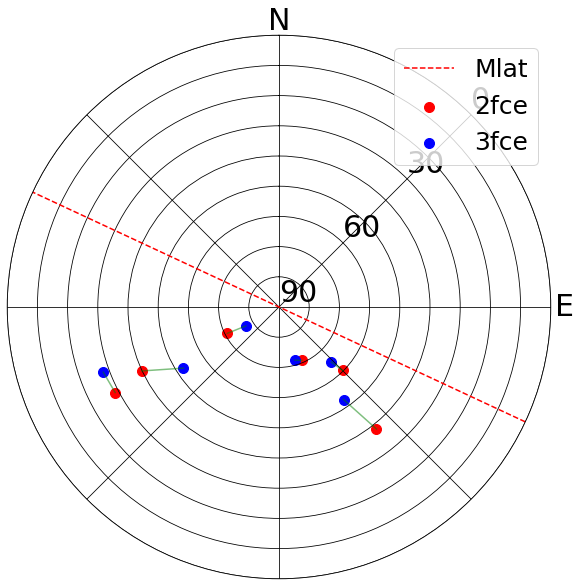

In [18]:
'Geographic South and Azimuth Within 10 deg Polar Plot'

file_list = range(42)
azi2_all = []
ele2_all = []
azi3_all = []
ele3_all = []

for i,angle in enumerate(azi_avg2_done):

    azi_diff = abs(azi_avg3_done[i] - angle)
    
    if azi_diff <= 10. :
        print(file_list[i],': ',ele_avg3_done[i])
        ele2_all.append(ele_avg2_done[i])
        azi2_all.append(angle)
        ele3_all.append(ele_avg3_done[i])
        azi3_all.append(azi_avg3_done[i])
print('Nummber of event pairs: ',len(ele2_all))

data_degrees2 = list(zip(azi2_all,ele2_all))
data_degrees3 = list(zip(azi3_all,ele3_all))
data_radians2 = [(np.deg2rad(a), r) for a, r in data_degrees2]
data_radians3 = [(np.deg2rad(a), r) for a, r in data_degrees3]
data_array2 = np.array(data_radians2)
data_array3 = np.array(data_radians3)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_rlim(bottom=90, top=0)
ax.xaxis.grid(True,color='k')
ax.yaxis.grid(True,color='k')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_yticklabels(['0','','','30','','','60','','','90'],fontsize=30,color='k')
ax.set_rlabel_position(45.0)
ax.set_xticklabels(['N', '', 'E', '', '', '', '', ''],fontsize=30,color='k')

r = 0.01
localBnorth = np.deg2rad(90. + 25.)
localBsouth = np.deg2rad(270. + 25.)
ax.plot([localBnorth,localBsouth], [r,r], color='r', linestyle='--', alpha=1,label='Mlat')

ax.scatter(data_array2[1:, 0], data_array2[1:, 1], color='r', s=100, alpha=1, label='2fce')
ax.scatter(data_array3[1:, 0], data_array3[1:, 1], color='b', s=100, alpha=1, label='3fce')

for (angle_2, radius_2), (angle_3, radius_3) in zip(data_array2[1:,:], data_array3[1:,:]):
    ax.plot([angle_2, angle_3], [radius_2, radius_3], color='g', alpha=0.5)
    x_2, y_2 = radius_2 * np.cos(angle_2), radius_2 * np.sin(angle_2)
    x_3, y_3 = radius_3 * np.cos(angle_3), radius_3 * np.sin(angle_3)
    distance = np.sqrt((x_3 - x_2) ** 2 + (y_3 - y_2) ** 2)

ax.legend(fontsize=25)
#plt.savefig('figures/figure6/polar_plot_south_and_within_10_deg_azi.png',transparent=True)
plt.show()
